In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay


In [6]:
# 2. Load Cleaned Data
df = pd.read_csv("cleaned_customer_data.csv")

# Optional: Preview structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              1000 non-null   int64  
 1   Age                     1000 non-null   int64  
 2   Gender                  1000 non-null   object 
 3   MaritalStatus           1000 non-null   object 
 4   IncomeLevel             1000 non-null   object 
 5   TotalSpend              1000 non-null   float64
 6   TransactionCount        1000 non-null   int64  
 7   Books                   1000 non-null   float64
 8   Clothing                1000 non-null   float64
 9   Electronics             1000 non-null   float64
 10  Furniture               1000 non-null   float64
 11  Groceries               1000 non-null   float64
 12  TotalInteractions       1000 non-null   float64
 13  UnresolvedInteractions  1000 non-null   float64
 14  LastLoginDate           1000 non-null   o

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpend,TransactionCount,Books,Clothing,Electronics,Furniture,Groceries,TotalInteractions,UnresolvedInteractions,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,416.50,1,0.00,0.00,416.50,0.00,0.00,1.0,0.0,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,1547.42,7,0.00,452.33,794.05,101.31,199.73,1.0,0.0,2023-12-05,5,Website,1
2,3,18,M,Single,Low,1702.98,6,241.06,51.07,0.00,823.27,587.58,1.0,0.0,2023-11-15,3,Website,0
3,4,21,M,Widowed,Low,917.29,5,0.00,44.22,367.09,382.39,123.59,2.0,1.0,2023-08-25,2,Website,0
4,5,21,M,Divorced,Medium,2001.49,8,0.00,0.00,683.54,398.89,919.06,0.0,0.0,2023-10-27,41,Website,0


In [7]:
# 3. Preprocessing
# Drop CustomerID and LastLoginDate
df['CustomerID'] = df['CustomerID'].astype(str)
df = df.drop(columns=['CustomerID', 'LastLoginDate'])

# Separate target variable
X = df.drop(columns='ChurnStatus')
y = df['ChurnStatus']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
# 4. Build Preprocessing + Model Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave numeric columns unchanged
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [9]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Train the Model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ServiceUsage'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [10]:
# 7. Make Predictions
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       159
           1       0.67      0.05      0.09        41

    accuracy                           0.80       200
   macro avg       0.73      0.52      0.49       200
weighted avg       0.77      0.80      0.72       200

📊 Confusion Matrix:


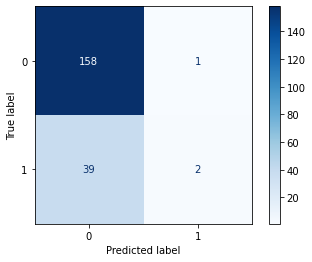

📈 ROC-AUC Score: 0.517


In [11]:
# 8. Evaluation Metrics
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)
disp.plot(cmap='Blues')
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"📈 ROC-AUC Score: {roc_auc:.3f}")

In [12]:
# 9. Feature Importance (Optional)
# Get feature names after one-hot encoding
encoded_features = model_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(encoded_features) + numeric_cols

# Get feature importances from the Random Forest
importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

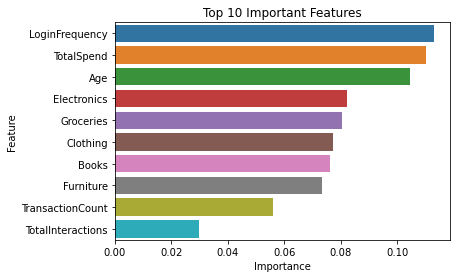

In [13]:
# Plot top 10 features
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features')
plt.show()